In [1]:
import os
os.environ['PYSPARK_PYTHON'] = 'python2'
import pyspark
sc = pyspark.SparkContext('local[*]')
#Load the CSV file into a RDD
autoData = sc.textFile("data/auto-data.csv")
autoData.cache()

data/auto-data.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:-2

In [2]:
#Remove the first line (contains headers)
firstLine = autoData.first()
dataLines = autoData.filter(lambda x: x != firstLine)
dataLines.count()

197

In [3]:
from pyspark.sql import SQLContext,Row
sqlContext = SQLContext(sc)

In [4]:
import math
from pyspark.mllib.linalg import Vectors

In [5]:
#Convert to Local Vector.
def transformToNumeric( inputStr) :
    attList=inputStr.split(",")

    doors = 1.0 if attList[3] =="two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    #Filter out columns not wanted at this stage
    values= Vectors.dense([ doors, \
                     float(body),  \
                     float(attList[7]),  \
                     float(attList[8]),  \
                     float(attList[9])  \
                     ])
    return values

In [6]:
autoVector = dataLines.map(transformToNumeric)
autoVector.persist()

PythonRDD[4] at RDD at PythonRDD.scala:43

In [7]:
autoVector.collect()

[DenseVector([1.0, 2.0, 69.0, 4900.0, 31.0]),
 DenseVector([1.0, 2.0, 48.0, 5100.0, 47.0]),
 DenseVector([1.0, 2.0, 68.0, 5000.0, 30.0]),
 DenseVector([1.0, 2.0, 62.0, 4800.0, 35.0]),
 DenseVector([1.0, 2.0, 68.0, 5500.0, 37.0]),
 DenseVector([1.0, 2.0, 60.0, 5500.0, 38.0]),
 DenseVector([1.0, 1.0, 69.0, 5200.0, 31.0]),
 DenseVector([1.0, 2.0, 68.0, 5500.0, 37.0]),
 DenseVector([1.0, 2.0, 68.0, 5500.0, 37.0]),
 DenseVector([1.0, 2.0, 68.0, 5000.0, 31.0]),
 DenseVector([1.0, 2.0, 68.0, 5500.0, 31.0]),
 DenseVector([2.0, 2.0, 68.0, 5500.0, 31.0]),
 DenseVector([2.0, 2.0, 68.0, 5500.0, 31.0]),
 DenseVector([1.0, 2.0, 70.0, 5400.0, 38.0]),
 DenseVector([1.0, 2.0, 62.0, 4800.0, 31.0]),
 DenseVector([1.0, 2.0, 68.0, 5500.0, 31.0]),
 DenseVector([1.0, 2.0, 58.0, 4800.0, 49.0]),
 DenseVector([2.0, 2.0, 62.0, 4800.0, 31.0]),
 DenseVector([1.0, 2.0, 76.0, 6000.0, 30.0]),
 DenseVector([2.0, 1.0, 70.0, 5400.0, 38.0]),
 DenseVector([1.0, 1.0, 69.0, 5200.0, 31.0]),
 DenseVector([1.0, 2.0, 68.0, 5500

In [8]:
#Centering and scaling. To perform this every value should be subtracted
#from that column's mean and divided by its Std. Deviation.

#Perform statistical Analysis and compute mean and Std.Dev for every column

In [9]:
from pyspark.mllib.stat import Statistics
autoStats=Statistics.colStats(autoVector)
colMeans=autoStats.mean()
colVariance=autoStats.variance()
colStdDev=map(lambda x: math.sqrt(x), colVariance)

In [10]:
#place the means and std.dev values in a broadcast variable
bcMeans=sc.broadcast(colMeans)
bcStdDev=sc.broadcast(colStdDev)

In [11]:
def centerAndScale(inVector) :
    global bcMeans
    global bcStdDev
    
    meanArray=bcMeans.value
    stdArray=bcStdDev.value
    
    valueArray=inVector.toArray()
    retArray=[]
    for i in range(valueArray.size):
        retArray.append( (valueArray[i] - meanArray[i]) /\
            stdArray[i] )
    return Vectors.dense(retArray)

In [12]:
csAuto = autoVector.map(centerAndScale)

In [13]:
csAuto.collect()

[DenseVector([-1.145, 0.9337, -0.9194, -0.4532, 0.9083]),
 DenseVector([-1.145, 0.9337, -1.4773, -0.0375, 3.3936]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453, 0.753]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611, 1.5297]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]),
 DenseVector([-1.145, 0.9337, -1.1585, 0.7941, 1.9956]),
 DenseVector([-1.145, -1.0656, -0.9194, 0.1704, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.8928, 0.5862, 1.9956]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611, 0.9083]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 0.9083]),
 DenseVector([-1.145, 0.9337, -1.2116, -0.6611, 3.7043]),
 DenseVector([0.869, 0.933

In [14]:
#Create a Spark Data Frame
autoRows=csAuto.map( lambda f:Row(features=f))

In [15]:
autoDf = sqlContext.createDataFrame(autoRows)

In [16]:
autoDf.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 10 rows



In [17]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(autoDf)
predictions = model.transform(autoDf)
predictions.collect()

[Row(features=DenseVector([-1.145, 0.9337, -0.9194, -0.4532, 0.9083]), prediction=1),
 Row(features=DenseVector([-1.145, 0.9337, -1.4773, -0.0375, 3.3936]), prediction=0),
 Row(features=DenseVector([-1.145, 0.9337, -0.9459, -0.2453, 0.753]), prediction=1),
 Row(features=DenseVector([-1.145, 0.9337, -1.1053, -0.6611, 1.5297]), prediction=1),
 Row(features=DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]), prediction=1),
 Row(features=DenseVector([-1.145, 0.9337, -1.1585, 0.7941, 1.9956]), prediction=1),
 Row(features=DenseVector([-1.145, -1.0656, -0.9194, 0.1704, 0.9083]), prediction=0),
 Row(features=DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]), prediction=1),
 Row(features=DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403]), prediction=1),
 Row(features=DenseVector([-1.145, 0.9337, -0.9459, -0.2453, 0.9083]), prediction=1),
 Row(features=DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 0.9083]), prediction=1),
 Row(features=DenseVector([0.869, 0.9337, -0.9459, 0.7941, 0

In [18]:
#Plot the results in a scatter plot
import pandas as pd

In [19]:
def unstripData(instr) :
    return ( instr["prediction"], instr["features"][0], \
        instr["features"][1],instr["features"][2],instr["features"][3])

In [20]:
unstripped=predictions.map(unstripData)
predList=unstripped.collect()
predPd = pd.DataFrame(predList)

In [21]:
import matplotlib.pylab as plt
plt.cla()
plt.scatter(predPd[3],predPd[4], c=predPd[0])

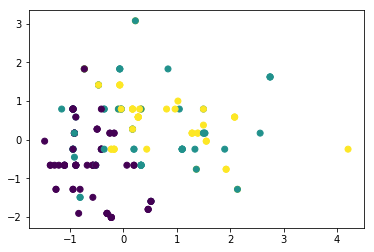

In [22]:
plt.show()